# Artigo 5
* Aluno: Paulo Henrique Costa Gontijo
* Matrícula: 15/0143800
* Lição: *From-scratch model*
* Notebooks: 
  * *Under the Hood: Training a Digit Classifier*
  * *Tabular Modeling Deep Dive*

| Hitórico de versão | Data |
|:--------------------:|:------:|
| v1 | 2/01/2023 |

## Propósito
Este artigo tem a intenção de documentar o passo a passo da quarta lição do curso, mostrando os blocos de códigos, o resultado das execuções, eventuais problemas encontrados e, se houver, as possíveis soluções para os problemas.

## Tema
A lição 5 do curso FastAi perpassa pelo objetivo de fundamentar o mecanismo, por debaixo dos panos, responsável por tornar possível o treinamento e aplicação de modelos de classificação, regressão, predição dentre outros. O conceito de gradiente estocástico pode ser considerado um ponto chave de compreensão da mesma, assim como variáveis numéricas e categóricas.

## Instalação das Bibliotecas


In [193]:
!pip install yfinance fastai -q

## Importação das Bibliotecas

In [194]:
import numpy as np
import pandas as pd
from fastai.tabular.all import *
from fastai.tabular.core import FillMissing
import fastai
import plotly.graph_objects as go
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import pandas_datareader.data as pdr

## Download do Dataset
Disponibilizado pela API do Yahoo Finance.

In [195]:
def get_refined_data(ticker, start, end):
  data = yf.download(ticker, start=start, end=end, period='1m')
  data['Shift'] = data['Close'].shift(-5)
  data['Date'] = data.index.values
  data['Date'] = data['Date'].astype(str).map(lambda x: x.replace('-',''))
  data['Date'] = data['Date'].astype(int)

  data['ema9'] = data['Close'].dropna().ewm(span=9, adjust=False).mean().dropna()
  data['ema80'] = data['Close'].dropna().ewm(span=80, adjust=False).mean().dropna()
  data['ema200'] = data['Close'].dropna().ewm(span=200, adjust=False).mean().dropna()
  return data.dropna()

In [196]:
def data_state(output):
    plt.figure(figsize=(40,10))
    sns.heatmap(output.isnull(),  cbar=False, cmap = 'summer')
    print(["Erros",np.sum(output.isnull().sum()),"Ativos",len(output.columns),"Núm. de dias", len(output)])

In [198]:
ticker = "VALE3.SA"
start="2000-01-01"
d = datetime.now().date() - timedelta(5)
end= d.strftime('%Y-%m-%d')

data = get_refined_data(ticker, start, end)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Shift,Date,ema9,ema80,ema200
Date,,,,,,,,,,,
2000-01-03,3.500000,3.542500,3.500000,3.500000,1.701703,585600,3.833333,20000103,3.500000,3.500000,3.500000
2000-01-04,3.466666,3.474166,3.416666,3.416666,1.661186,782400,3.841666,20000104,3.483333,3.497942,3.499171
2000-01-05,3.375000,3.416666,3.375000,3.416666,1.661186,1876800,3.879166,20000105,3.470000,3.495936,3.498350
2000-01-06,3.416666,3.500000,3.416666,3.416666,1.661186,792000,4.008333,20000106,3.459333,3.493978,3.497537
2000-01-07,3.458333,3.559166,3.458333,3.541666,1.721961,5347200,4.083333,20000107,3.475800,3.495156,3.497976
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-16,87.000000,87.320000,84.510002,85.680000,85.680000,37762100,86.320000,20221216,86.224018,77.777255,78.207773
2022-12-19,85.000000,85.580002,84.239998,85.370003,85.370003,27508500,87.110001,20221219,86.053215,77.964730,78.279039
2022-12-20,85.370003,87.250000,85.309998,85.750000,85.750000,22657300,89.190002,20221220,85.992572,78.156959,78.353377


## Conferência de integridade
A função abaixo plota os valores nulos, presentes no dataset.

['Erros', 0, 'Ativos', 11, 'Núm. de dias', 5773]


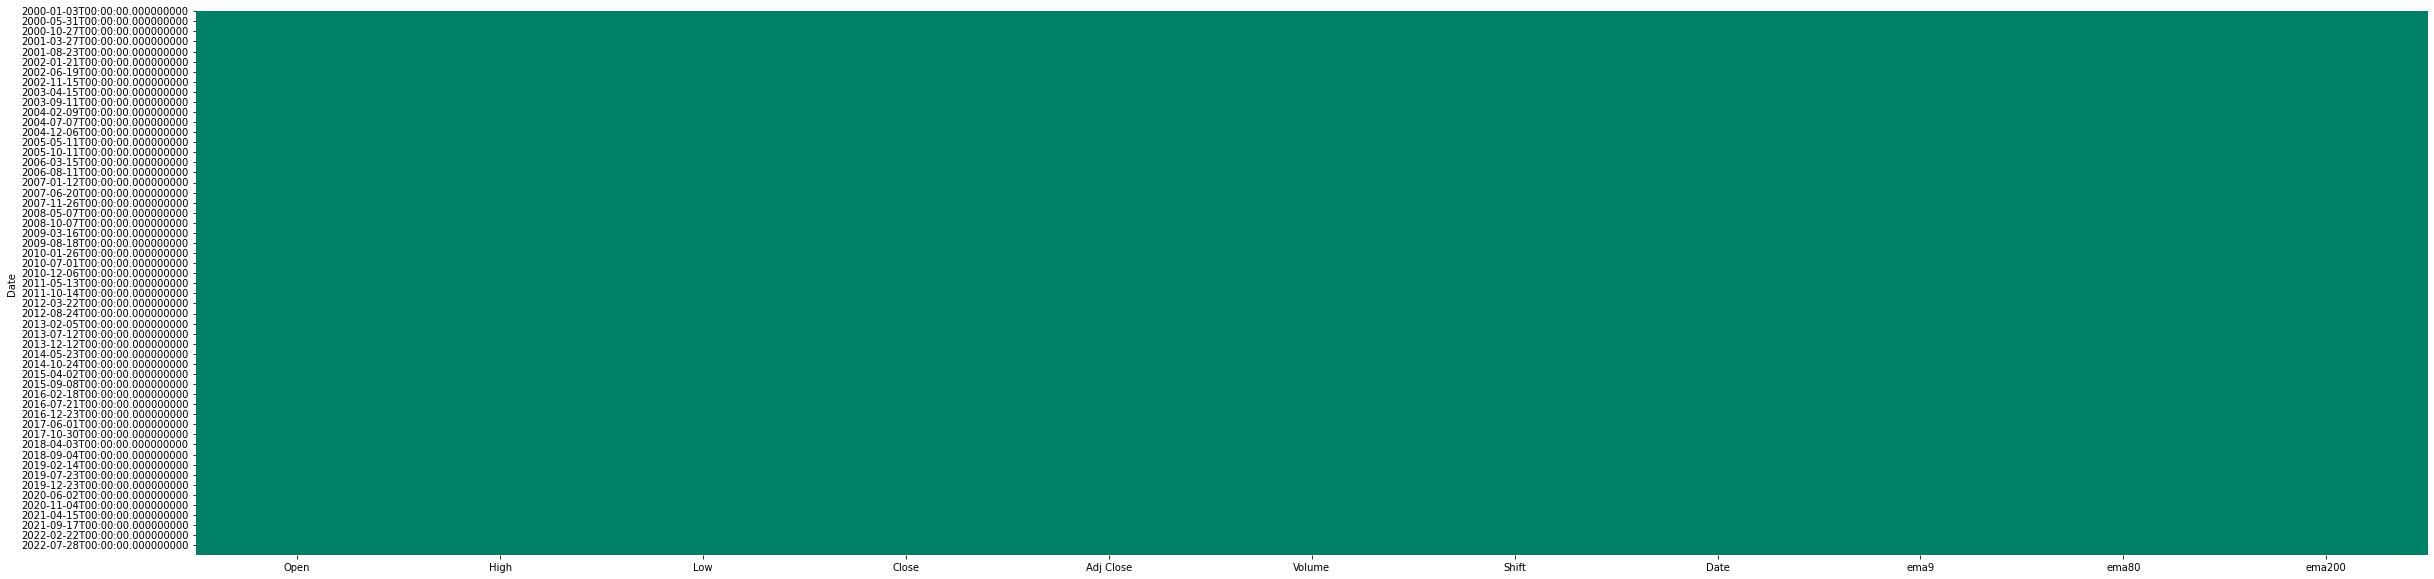

In [199]:
data_state(data)

In [200]:
def plot_candlestick(data):
  fig = go.Figure(data=[go.Candlestick(x=data.index.values,
                  open=data['Open'],
                  high=data['High'],
                  low=data['Low'],
                  close=data['Close'])])
  
  fig.add_trace(go.Scatter(x=data.index,
                          y=data['ema9'],
                          opacity=0.7,
                          line=dict(color='pink', width=2),
                          name='Ema9'))

  fig.add_trace(go.Scatter(x=data.index,
                          y=data['ema80'],
                          opacity=0.7,
                          line=dict(color='blue', width=2),
                          name='Ema80'))

  fig.add_trace(go.Scatter(x=data.index,
                          y=data['ema200'],
                          opacity=0.7,
                          line=dict(color='yellow', width=2),
                          name='Ema200'))

  fig.update_layout(xaxis_rangeslider_visible=False)
  fig.show()

plot_candlestick(data)

In [201]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Shift,Date,ema9,ema80,ema200
Date,,,,,,,,,,,
2022-12-16,87.000000,87.320000,84.510002,85.680000,85.680000,37762100,86.320000,20221216,86.224018,77.777255,78.207773
2022-12-19,85.000000,85.580002,84.239998,85.370003,85.370003,27508500,87.110001,20221219,86.053215,77.964730,78.279039
2022-12-20,85.370003,87.250000,85.309998,85.750000,85.750000,22657300,89.190002,20221220,85.992572,78.156959,78.353377
2022-12-21,86.900002,87.400002,85.820000,86.239998,86.239998,39183700,88.989998,20221221,86.042057,78.356540,78.431851
2022-12-22,86.279999,86.650002,84.690002,85.750000,85.750000,19429200,88.879997,20221222,85.983646,78.539095,78.504668


## Carregamento dos Dados 
Utilizando a classe **TabularPandas**, a fim de criar o bloco de dados insumo para treinamento do modelo. As variáveis definidas abaixo significam:

* `y_names`: Coluna alvo de regressão.
* `cat_names`: Coluna de variáveis categóricas, caso existissem no exemplo.
* `cont_names`: Coluna de variáveis contínuas, ou seja, estão em formato numérico.
* `splits`: representa uma função de segregação das vases de teste e validação, aplicando a proporção passada em *valid_pct*.


In [202]:
y_names = 'Shift'
cat_names = []
cont_names = ['Open', 'High', 'Low', 'Volume', 'Close', 'Date', 'ema9', 'ema80', 'ema200']
splits = RandomSplitter(valid_pct=0.2)(range_of(data))
splits

((#4619) [2260,4852,820,4580,4495,5392,4087,4842,4251,3871...],
 (#1154) [1678,4036,447,5205,4144,910,2694,4525,4415,1623...])

In [203]:
to = TabularPandas(df=data, 
                   cat_names=cat_names, 
                   cont_names=cont_names, 
                   y_names=y_names, 
                   y_block=RegressionBlock(), 
                   splits=splits)

## Conferindo o carregamento

In [204]:
dls = to.dataloaders()
print('Valid')
dls.valid.show_batch()
print('Train')
dls.train.show_batch()

Valid


,Open,High,Low,Volume,Close,Date,ema9,ema80,ema200,Shift
0,24.750000,25.250000,24.254999,1339000.0,24.750000,20060626.0,24.417860,25.661671,24.546516,26.799999
1,12.490000,12.980000,12.480000,4587900.0,12.690000,20160104.0,12.772699,15.269910,17.893642,10.240000
2,4.250000,4.266666,4.250000,11500800.0,4.266666,20010920.0,4.188591,4.259795,4.122503,4.325000
3,59.900002,60.330002,59.369999,16481700.0,60.000000,20200908.0,60.429466,57.633137,53.615383,60.970001
4,15.140000,15.320000,14.820000,5954000.0,14.950000,20160610.0,15.649776,15.433567,15.835459,15.280000
5,7.100000,7.166666,7.000000,1387200.0,7.000000,20030630.0,7.116930,7.347118,7.339048,7.442500
6,49.000000,49.299999,48.259998,3991200.0,48.400002,20100728.0,47.441776,48.199081,47.834900,50.650002
7,35.630001,36.180000,35.220001,17624400.0,36.180000,20171212.0,35.699020,33.373425,30.992409,37.849998
8,29.830000,30.090000,29.639999,4949900.0,30.040001,20170712.0,29.144770,28.014713,26.508236,29.900000
9,26.002501,26.200001,25.750000,4897600.0,26.100000,20060410.0,26.039896,25.001787,23.372871,26.002501


Train


,Open,High,Low,Volume,Close,Date,ema9,ema80,ema200,Shift
0,23.697500,23.837500,23.250000,3102400.0,23.697500,20051208.0,23.801210,22.609192,20.734188,24.000000
1,30.900000,30.900000,29.650000,10680100.0,29.660000,20170726.0,29.522512,28.377056,26.822132,31.110001
2,43.259998,43.259998,42.230000,29050700.0,42.459999,20200420.0,43.149429,45.855297,47.886196,44.610001
3,57.230000,57.630001,56.860001,2203800.0,57.080002,20110132.0,58.423149,55.901089,52.767334,56.759998
4,7.407500,7.407500,7.216666,1876800.0,7.300000,20030608.0,7.299656,7.438912,7.370105,7.100000
5,53.400002,55.549999,53.400002,1863900.0,55.500000,20080212.0,52.997631,55.508167,51.148636,57.590000
6,37.799999,38.000000,37.049999,1766000.0,37.055000,20070328.0,37.627563,34.238590,30.464684,40.250000
7,9.000833,9.166666,9.000000,3964800.0,9.066666,20021212.0,8.743277,7.619709,6.701258,8.341666
8,3.666666,3.875000,3.666666,278400.0,3.875000,20010118.0,3.689602,3.600187,3.586514,4.082500
9,4.341666,4.433333,4.341666,960000.0,4.416666,20010814.0,4.370853,4.277295,4.085453,4.299166


## Definindo range alvo
É importante passar para a função um range alvo da variável que deseja fazer a regressão. Para tal, definimos *tensors* - estrutura original da biblioteca **PyTorch**, a qual se assemelha com uma estrutura **numpy**. 

> Caso a estrutura de tensores mostrada não seja aplicada, provavelmente a função não executará o treinamento de forma correta.

* A lógica por trás da definição do range, envolve em captar a maior e menor variação de preço, já vista no ativo, adicionando o devio padrão e multiplicando este peso ao último valor do dataset.

In [205]:
ret = ((data['Close'] / data['Open'])-1)
std = data['Close'].std()
min_ret = (ret.min() + 1 + std/100)
max_ret = (ret.max() + 1 + std/100)

max = data['Close'].iloc[-1] * max_ret
min = data['Close'].iloc[-1] * min_ret

In [206]:
# y_range = (torch.tensor(min).cuda(), torch.tensor(max).cuda())
y_range = (torch.tensor(min), torch.tensor(max))
y_range

(tensor(88.0819, dtype=torch.float64), tensor(117.1983, dtype=torch.float64))

## Definindo metricas de treinamento
Todas as métricas em comentário foram testadas e, algumas combinações de função de loss e métricas performaram melhor. Em destaque `SpearmanCorrCoef` foi uma das que mais performaram. 

In [207]:
#mse
#rmse
#mae
#msle
#exp_rmspe
#ExplainedVariance()
#R2Score()
#PearsonCorrCoef()
#SpearmanCorrCoef()
#loss_func=MSELossFlat()
#loss_func=L1LossFlat()
#DiceLoss()
learn = None
learn = tabular_learner(dls, metrics=rmse, loss_func=L1LossFlat())

## Otimizando taxa de aprendizado
Utilizando a função abaixo é possível encontrar a melhor taxa de aprendizado para o gradiente descendente.

SuggestedLRs(valley=0.0691830962896347)


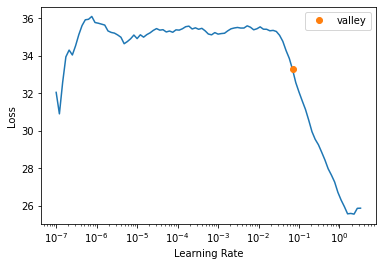

In [208]:
lr_rate = learn.lr_find()
print(lr_rate)

## Treinando o modelo
Utilizando a taxa encontrada e 100 épocas.

In [209]:
learn.fit_flat_cos(100, lr=lr_rate[0])

epoch,train_loss,valid_loss,_rmse,time
0,6.335179,3.271719,4.212233,00:01
1,4.936197,6.404306,6.857403,00:00
2,4.409717,3.796064,5.720011,00:01
3,4.651048,1.753369,2.755741,00:01
4,4.659204,4.179950,6.452106,00:01
5,4.073287,2.974262,3.752691,00:01
6,3.994386,1.710782,2.556690,00:01
7,4.077724,3.542121,4.201190,00:02
8,4.454927,4.637223,6.161043,00:01
9,4.186357,6.288010,7.306468,00:01


In [210]:
learn.show_results()

,Open,High,Low,Volume,Close,Date,ema9,ema80,ema200,Shift,Shift_pred
0,33.290001,34.049999,33.150002,23741300.0,34.049999,20171120.0,33.062649,32.318436,30.233759,36.250000,33.536705
1,5.116666,5.166666,5.083333,9441600.0,5.166666,20020324.0,5.136894,4.732804,4.463747,5.240833,5.903035
2,24.850000,25.809999,24.750000,111172304.0,25.700001,20060628.0,24.700985,25.606993,24.556904,25.674999,24.014040
3,7.199166,7.250000,7.191666,5097600.0,7.247500,20021008.0,7.152788,6.579775,5.932298,7.208333,7.940364
4,34.549999,35.930000,33.500000,4379500.0,34.810001,20090212.0,35.367184,32.013432,37.914314,35.020000,33.580154
5,3.991666,3.991666,3.983333,240000.0,3.983333,20010420.0,4.000036,3.950344,3.804610,4.041666,4.912086
6,64.169998,64.699997,63.560001,24144700.0,64.510002,20220908.0,65.045822,72.887070,79.289429,68.349998,64.208305
7,60.299999,62.910000,60.150002,2698300.0,61.349998,20071128.0,59.702763,56.435581,48.516216,64.550003,60.477264
8,9.875833,10.208333,9.875833,2745600.0,9.916666,20030920.0,9.644568,8.569105,7.963961,9.502500,10.531639


## Validação
Além da validação do framework, valida-se em tempo diferente do treinamento/validação do treinamento do modelo.

In [211]:
data_valid = get_refined_data(ticker, start="2022-01-01", end="2023-01-01")
data_valid

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Shift,Date,ema9,ema80,ema200
Date,,,,,,,,,,,
2022-01-03,79.000000,79.970001,78.000000,78.000000,71.168777,18557200,83.000000,20220103,78.000000,78.000000,78.000000
2022-01-04,78.510002,79.070000,76.900002,77.080002,70.329346,18178700,84.580002,20220104,77.816000,77.977284,77.990846
2022-01-05,77.370003,78.680000,77.129997,77.809998,70.995415,22039000,85.500000,20220105,77.814800,77.973153,77.989046
2022-01-06,78.639999,80.349998,78.309998,79.379997,72.427917,22044100,84.199997,20220106,78.127839,78.007890,78.002887
2022-01-07,80.400002,84.000000,79.790001,84.000000,76.643288,35213100,84.690002,20220107,79.302271,78.155844,78.062559
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-16,87.000000,87.320000,84.510002,85.680000,85.680000,37762100,86.320000,20221216,86.224018,77.773234,77.479766
2022-12-19,85.000000,85.580002,84.239998,85.370003,85.370003,27508500,87.110001,20221219,86.053215,77.960809,77.558276
2022-12-20,85.370003,87.250000,85.309998,85.750000,85.750000,22657300,89.190002,20221220,85.992572,78.153135,77.639786


In [212]:
plot_candlestick(data_valid)

In [213]:
test_df = data_valid.copy()
test_df.drop(['Shift'], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

In [214]:
preds = learn.get_preds(dl=dl)
pred_list = []
for i in range(len(preds[0])): pred_list.append(preds[0][i].numpy()[0])
df_valid = pd.DataFrame(pred_list, index=data_valid.index.values, columns=['predict_close'])
df_valid['predict_close'] = df_valid['predict_close']
df_valid['real_close'] = data_valid['Close']

['Erros', 0, 'Ativos', 2, 'Núm. de dias', 245]


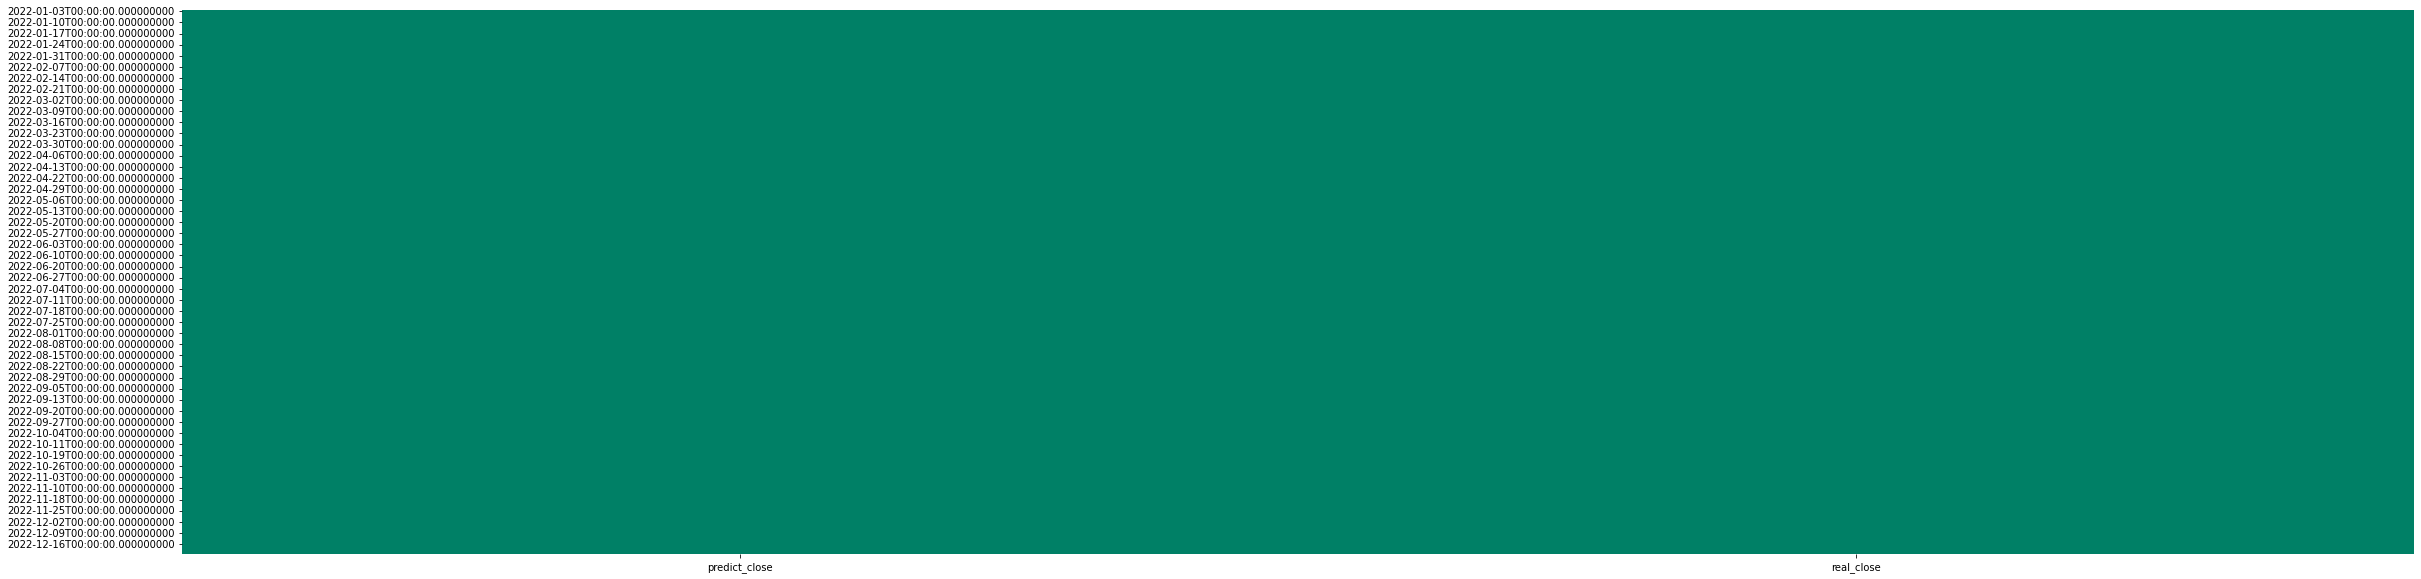

In [215]:
data_state(df_valid)

## Predição

In [216]:
import plotly.express as px
fig = px.line(df_valid, x=df_valid.index.values, y=df_valid.columns)
fig.show()

## Deploy do modelo
O modelo foi implantado no ambiente **HuggingFace**, conforme em outras lições e pode ser acessado por este link: https://huggingface.co/spaces/paulohgontijoo/tabular-fastai-lesson-5

In [217]:
learn.export('/home/model.pkl')

* Ao executar o comando acima, utilizando a métrica `SpearmenCorrCoef` o seguite erro foi apresentado:

```shell
AttributeError                            Traceback (most recent call last)

<ipython-input-46-da3b055ac77f> in <module>
----> 1 learn.export('/home/model.pkl')

2 frames

/usr/local/lib/python3.8/dist-packages/torch/serialization.py in _save(obj, zip_file, pickle_module, pickle_protocol)
    633     pickler = pickle_module.Pickler(data_buf, protocol=pickle_protocol)
    634     pickler.persistent_id = persistent_id
--> 635     pickler.dump(obj)
    636     data_value = data_buf.getvalue()
    637     zip_file.write_record('data.pkl', data_value, len(data_value))

AttributeError: Can't pickle local object 'SpearmanCorrCoef.<locals>.spearmanr' 
```

* **Solução:** Trocar a métrica para `RMSE`, a qual também performa na solução. 

# Referências Bibliográficas

> https://course.fast.ai/Lessons/lesson5.html, acessado em 02/01/2023

> https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb, acessado em 02/01/2023.

> https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb, acessado em 02/01/2023.

> https://walkwithfastai.com/Regression_and_Permutation_Importance, acessado em 02/01/2023.

> https://forums.fast.ai/t/multiple-target-regression-with-fast-ai-v2-tabular/71260/10, acessado em 03/01/2023.

> https://docs.fast.ai/metrics.html#regression, acessado em 03/01/2023.

> https://docs.fast.ai/learner.html#learner.get_preds, acessado em 03/01/2023.

> https://walkwithfastai.com/lr_finder, acessado em 04/01/2023.

> https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics, acessado em 04/01/2023.

> https://plainenglish.io/blog/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682, acessado em 04/01/2023.

> https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity, acessado em 04/01/2023.